# Marginal Abatement Cost Curve (MACC) Analysis

This notebook demonstrates the use of the MACC analysis module to evaluate the cost-effectiveness of transitioning existing fossil fuel power plants to wind, solar, and natural gas with or without carbon capture and storage.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Import the MACC analysis module
import macc_analysis as macc

## Configuration

Set up the configuration for the analysis. You can modify these parameters to explore different scenarios.

In [2]:
# Get the current working directory (notebooks directory)
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Set project root to one level up from current directory
project_root = os.path.dirname(current_dir)
print(f"Project root directory: {project_root}")

# Define configuration with correct paths
config = {
    'discount_rate': 0.06,
    'gas_price': 3.5,  # $/MMBtu
    'analysis_year': 2024,
    'plant_lifetime': 30,  # years
    'ngcc_cf': 0.59,  # capacity factor for NGCC
    'battery_storage_ratio': 25/150,  # MWh per MW of installed capacity
    'macc_filter_min': -1000,  # $/tonne CO2
    'macc_filter_max': 1000,   # $/tonne CO2
    'data_dir': os.path.join(project_root, 'data'),  # Use absolute path to data directory
    'output_dir': os.path.join(project_root, 'output', 'baseline'),
    'save_intermediates': True,
    'save_figures': True
}

# Create output directory
os.makedirs(config['output_dir'], exist_ok=True)

# Verify data directory exists
if not os.path.exists(config['data_dir']):
    print(f"WARNING: Data directory not found at {config['data_dir']}")
else:
    # List files in data directory to verify
    print("\nFiles in data directory:")
    for file in os.listdir(config['data_dir']):
        print(f"  - {file}")

Current working directory: /Users/dhruvsuri/Code/US-macc/notebooks
Project root directory: /Users/dhruvsuri/Code/US-macc

Files in data directory:
  - PVOUT_2.tif
  - Power plant capital cost.xlsx
  - USA_capacity-factor_IEC1.tif
  - 3_1_Generator_Y2023.xlsx
  - 2___Plant_Y2023.xlsx
  - 2023_annual_emissions_CEMS.csv
  - processed
  - raw


## Run the Baseline Analysis

Run the MACC analysis with the baseline configuration.

2025-03-07 02:10:43,180 - macc_analysis - INFO - Running MACC analysis scenario: baseline
2025-03-07 02:10:43,184 - macc_analysis - INFO - Loaded emissions data with 1343 records
2025-03-07 02:10:43,186 - macc_analysis - INFO - Found 1121 unique facilities in emissions data
2025-03-07 02:10:52,545 - macc_analysis - INFO - Loaded plant data with 26011 records
2025-03-07 02:10:52,566 - macc_analysis - INFO - Filtered to 4092 plant records
/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_level_attributes.rename(columns={'Plant Code': 'Facility ID'}, inplace=True)
2025-03-07 02:10:52,702 - macc_analysis - INFO - Loaded capital cost data with 108 records
/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:314: SettingWithCopyWarning: 
A va

Total CO2 emissions analyzed: 0.77 Gt
Emissions with negative abatement cost: 0.12 Gt (15.6%)
Number of facilities analyzed: 659


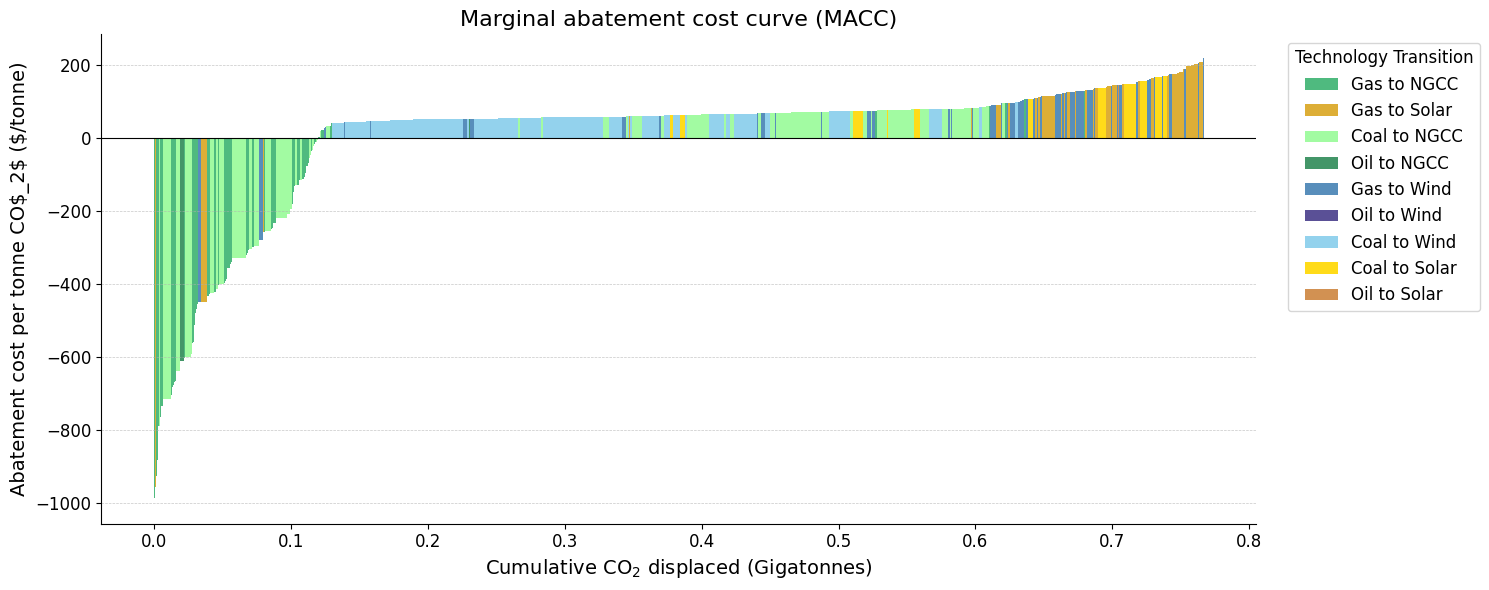

In [3]:
# Run the analysis
merged_df, macc_data, summary = macc.run_scenario(config, 'baseline')

# Display summary of results
print(f"Total CO2 emissions analyzed: {summary['total_emissions_gt']:.2f} Gt")
print(f"Emissions with negative abatement cost: {summary['negative_cost_emissions_gt']:.2f} Gt ({summary['negative_cost_percentage']:.1f}%)")
print(f"Number of facilities analyzed: {summary['facility_count']}")

## Visualize the MACC Curve

Create and display the MACC curve for the baseline scenario.

2025-03-07 02:11:04,958 - macc_analysis - INFO - MACC curve saved to /Users/dhruvsuri/Code/US-macc/output/baseline/macc_curve.png


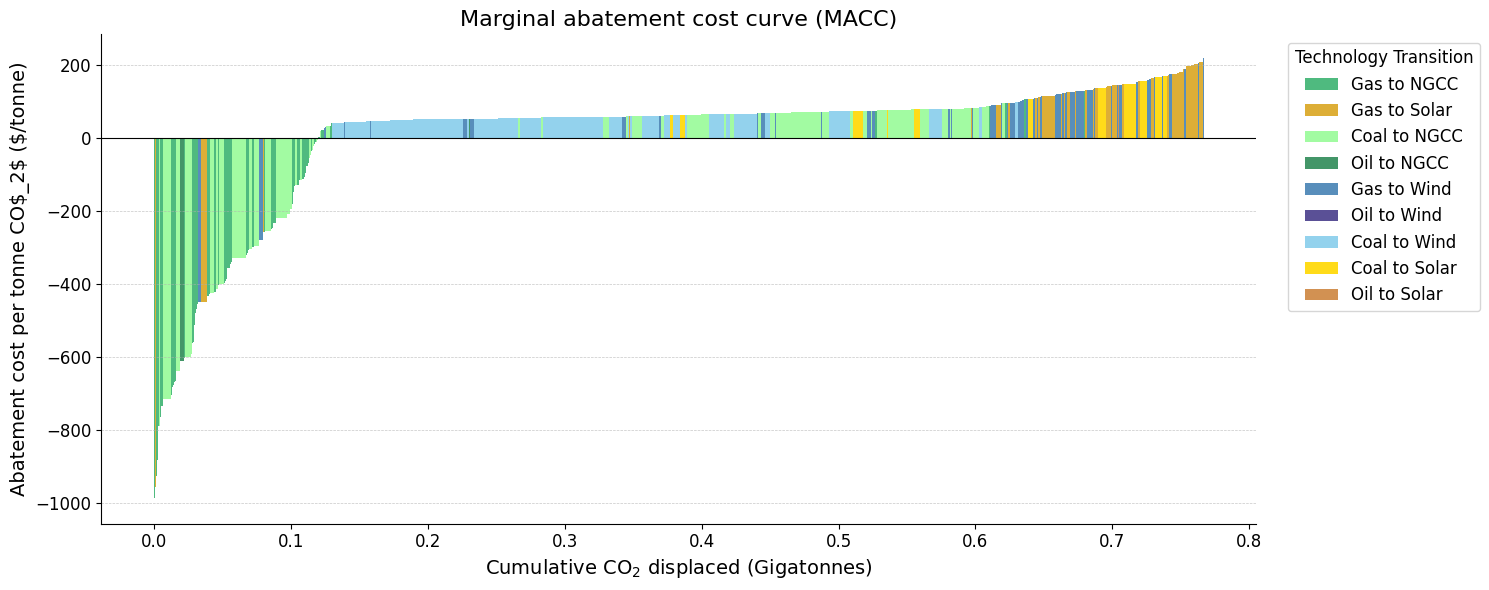

In [4]:
# Plot the MACC curve
fig = macc.plot_macc_curve(macc_data, config)
plt.show()

## Visualize a Map of Transitions

Create and display the MACC curve for the baseline scenario on map.

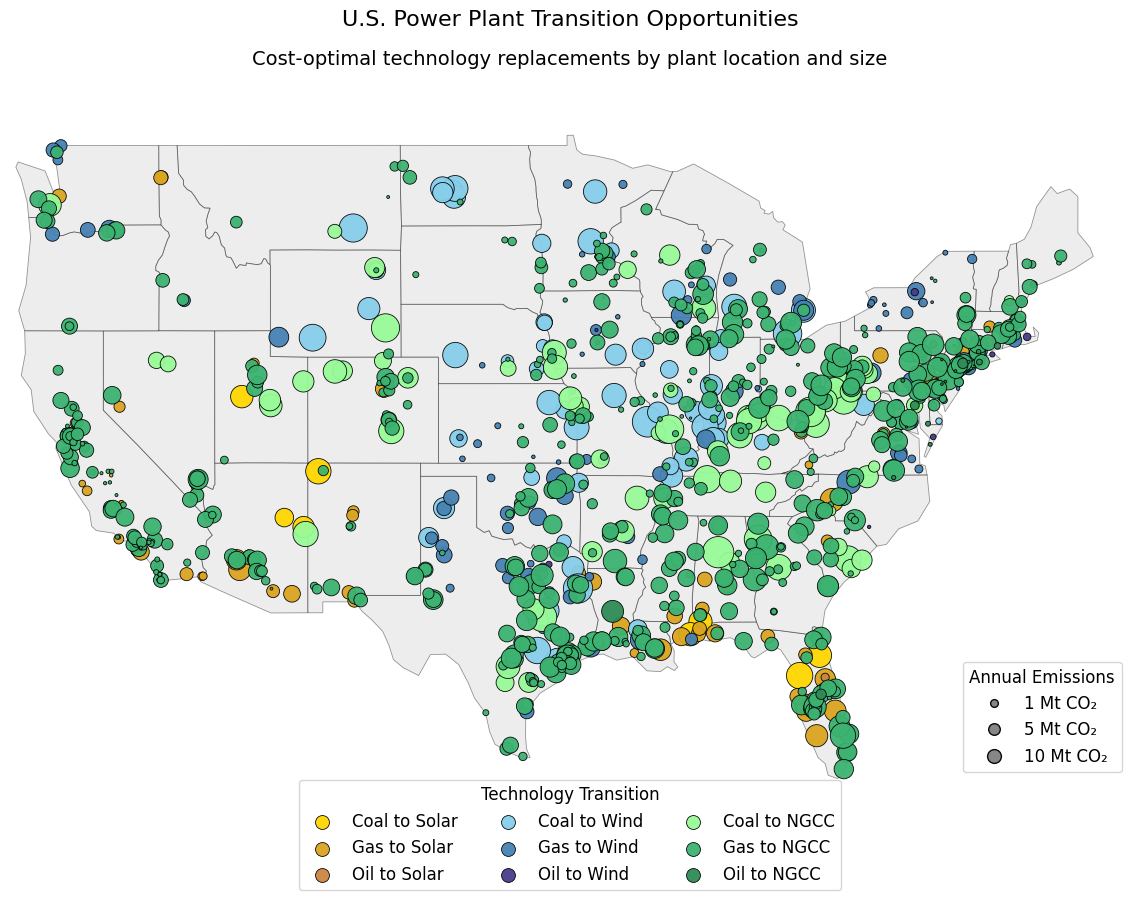

In [5]:
# Create the transition map
fig = macc.create_transition_map(
    merged_df=merged_df,
    config=config,
    output_path=os.path.join(config['output_dir'], "transition_map.png")
)
plt.show()

In [6]:
# Save the MACC data and merged_df for use in air pollution analysis
macc_output_dir = config['output_dir']
macc_data.to_csv(os.path.join(macc_output_dir, 'macc_curve_data.csv'), index=False)
merged_df.to_csv(os.path.join(macc_output_dir, 'macc_calculations.csv'), index=False)
print(f"Saved MACC data to {macc_output_dir}")

Saved MACC data to /Users/dhruvsuri/Code/US-macc/output/baseline


In [8]:
# Now process for air pollution analysis
from macc_to_emissions import process_macc_results_for_emissions, prepare_inmap_input

# Define output directory for air pollution results
air_pollution_dir = os.path.join(os.path.dirname(config['output_dir']), 'air_pollution')
os.makedirs(air_pollution_dir, exist_ok=True)

# Process MACC results directly (using the in-memory data rather than loading from files)
gdf = process_macc_results_for_emissions(macc_data, merged_df, air_pollution_dir)

2025-03-07 02:11:42,861 - pyogrio._io - INFO - Created 322 records


Processing MACC results for air pollution modeling...
Found 322 plants targeted for NGCC conversion
Modified emissions data saved to /Users/dhruvsuri/Code/US-macc/output/air_pollution/ngcc_converted_plants_emissions.gpkg
CSV version saved to /Users/dhruvsuri/Code/US-macc/output/air_pollution/ngcc_converted_plants_emissions.csv
State summary saved to /Users/dhruvsuri/Code/US-macc/output/air_pollution/ngcc_conversion_by_state.csv


In [9]:
if gdf is not None:
    # Prepare InMAP input file
    inmap_path = prepare_inmap_input(gdf, air_pollution_dir)
    
    print("\nProcessing complete!")
    print(f"The InMAP input file is ready at: {inmap_path}")
    print("This file can be used with the InMAP model to assess air pollution impacts.")
    print("Example usage: resultsISRM = run_sr(inmap_path, model='isrm', emis_units='tons/year')")
else:
    print("Processing could not be completed due to missing data.")

2025-03-07 02:11:53,708 - pyogrio._io - INFO - Created 322 records


InMAP input file saved to /Users/dhruvsuri/Code/US-macc/output/air_pollution/ngcc_converted_for_inmap.gpkg

Processing complete!
The InMAP input file is ready at: /Users/dhruvsuri/Code/US-macc/output/air_pollution/ngcc_converted_for_inmap.gpkg
This file can be used with the InMAP model to assess air pollution impacts.
Example usage: resultsISRM = run_sr(inmap_path, model='isrm', emis_units='tons/year')


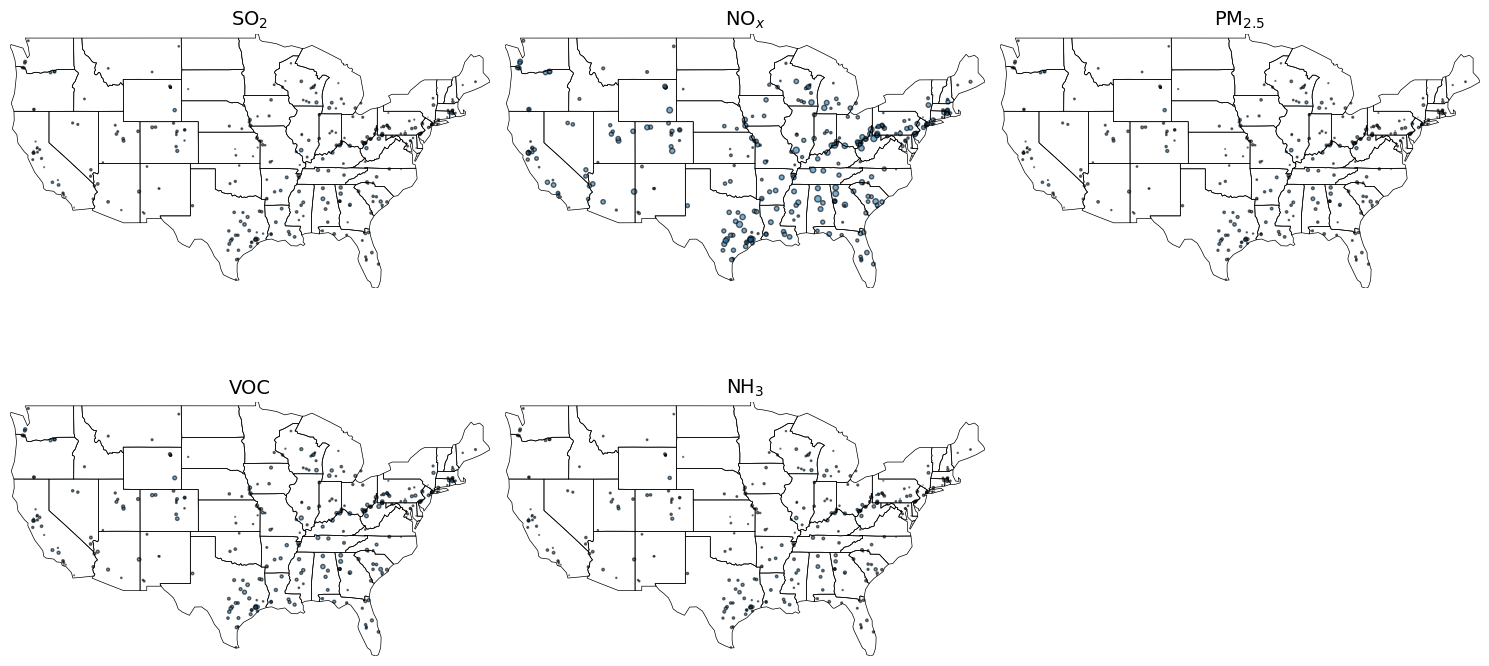

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

# 1. Load & Convert CRS
us_states = gpd.read_file("../data/raw/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
us_states = us_states[~us_states['name'].isin(['Alaska', 'Hawaii'])]
us_states = us_states.to_crs(epsg=4269)  # match egu_gdf if egu_gdf is in EPSG:4269

egu_gdf = gdf.to_crs(epsg=4269)     # ensure egu_gdf also in EPSG:4269

# 2. Pollutants
pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

# 3. Plot
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=3, sharex=True, sharey=True)
#plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.01, hspace=0.01)

minx, miny, maxx, maxy = us_states.total_bounds

for i, ax in enumerate(axes.flat):
    if i < len(pols):
        us_states.boundary.plot(ax=ax, color="black", linewidth=0.5)
        egu_gdf.plot(
            ax=ax,
            markersize=egu_gdf[pols[i]]**0.5 / 2,
            alpha=0.6,
            edgecolor='black'
        )
        ax.set_title(pol_names[i], fontsize=14)

        
        # Zoom to lower 48
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

# 4. Remove the last unused subplot
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

In [12]:
# Below are the helper functions for the run_sr function
import time
import numpy as np
import zarr
from shapely.geometry import Polygon, Point
import pandas as pd
import geopandas as gpd
import s3fs

def rect(i, w, s, e, n):
    x = [w[i], e[i], e[i], w[i], w[i]]
    y = [s[i], s[i], n[i], n[i], s[i]]
    return x, y

def poly(sr):
    ret = []
    w = sr["W"][:]
    s = sr["S"][:]
    e = sr["E"][:]
    n = sr["N"][:]
    for i in range(52411):
        x, y = rect(i, w, s, e, n)
        ret.append(Polygon([[x[0],y[0]],[x[1],y[1]],[x[2],y[2]],
                            [x[3],y[3]],[x[4],y[4]]]))
    return ret

# Define the run_sr function
def run_sr(emis, model, emis_units="tons/year"):
    start = time.time()
    
    # Load spatial receptor grid (SR)
    url = 's3://inmap-model/isrm_v1.2.1.zarr/'
    fs = s3fs.S3FileSystem(anon=True, client_kwargs={"region_name": "us-east-2"})
    sr = zarr.open(
        store=url,
        mode="r",
        storage_options={"anon": True, "client_kwargs": {"region_name": "us-east-2"}}
    )   

    # Build the grid geometry
    p = poly(sr)
    print("Making polygons as geometry.")

    # Create grid GeoDataFrame
    df = pd.DataFrame({'Location': range(52411)})
    gdf = gpd.GeoDataFrame(df, geometry=p, crs="+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1")
    
    # Ensure emis has CRS set correctly
    if emis.crs is None:
        print("Warning: emis CRS is None. Assigning default CRS (WGS84).")
        emis = emis.set_crs("EPSG:4326")

    # Convert emissions to match grid CRS
    emis = emis.to_crs(gdf.crs)

    # Spatial join (match emissions to grid)
    join_right_df = gdf.sjoin(emis, how="right")

    # Debugging: Print missing locations
    missing_count = join_right_df.Location.isna().sum()
    print(f"Finished joining dataframes. Missing locations: {missing_count}")

    # Drop NaN locations if any exist
    join_right_df = join_right_df.dropna(subset=["Location"])
    
    index = join_right_df.Location.astype(int).tolist()  # Ensure integer type

    # Get unique indices for emissions
    ppl = np.unique(index).tolist()

    # Create dictionary for mapping locations to index
    dictionary = {ppl[i]: i for i in range(len(ppl))}

    # Load Source-Receptor (SR) matrix data
    SOA = sr['SOA'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("SOA data allocated.")
    pNO3 = sr['pNO3'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNO3 data allocated.")
    pNH4 = sr['pNH4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNH4 data allocated.")
    pSO4 = sr['pSO4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pSO4 data allocated.")
    PM25 = sr['PrimaryPM25'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("PrimaryPM25 data allocated.")

    # Initialize output data arrays
    SOA_data, pNO3_data, pNH4_data, pSO4_data, PM25_data = 0.0, 0.0, 0.0, 0.0, 0.0

    # Calculate pollution data using emissions
    for i in range(len(index)):
        loc_idx = dictionary[index[i]]  # Get correct index
        SOA_data += SOA[0, loc_idx, :] * emis.VOC.iloc[i]
        pNO3_data += pNO3[0, loc_idx, :] * emis.NOx.iloc[i]
        pNH4_data += pNH4[0, loc_idx, :] * emis.NH3.iloc[i]
        pSO4_data += pSO4[0, loc_idx, :] * emis.SOx.iloc[i]
        PM25_data += PM25[0, loc_idx, :] * emis.PM2_5.iloc[i]

    data = SOA_data + pNO3_data + pNH4_data + pSO4_data + PM25_data

    print("Accessing data.")

    # Apply emission unit conversion factor
    fact = 28766.639 if emis_units == "tons/year" else 1

    # Compute final pollution metrics
    TotalPM25 = fact * data
    TotalPop = sr['TotalPop'][0:52411]
    MortalityRate = sr['MortalityRate'][0:52411]
    deathsK = (np.exp(np.log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523
    deathsL = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523

    # Create output GeoDataFrame
    ret = gpd.GeoDataFrame(pd.DataFrame({
        'SOA': fact * SOA_data,
        'pNO3': fact * pNO3_data,
        'pNH4': fact * pNH4_data,
        'pSO4': fact * pSO4_data,
        'PrimaryPM25': fact * PM25_data,
        'TotalPM25': TotalPM25,
        'deathsK': deathsK,
        'deathsL': deathsL
    }), geometry=p[:52411])

    print(f"Finished ({time.time() - start:.0f} seconds)")
    return ret

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.gridspec as gridspec
from pathlib import Path
import os

# ================================
# Step 1: Define paths and load data
# ================================

# Define paths
project_root = os.path.dirname(os.getcwd())
air_pollution_dir = os.path.join(project_root, 'output', 'air_pollution')
figure_dir = os.path.join(project_root, 'figures')
os.makedirs(figure_dir, exist_ok=True)

# Load the InMAP-formatted emissions data for the converted plants
print("Loading NGCC-converted emissions data for SR model...")
ngcc_inmap_file = os.path.join(air_pollution_dir, 'ngcc_converted_for_inmap.gpkg')
ngcc_full_data_file = os.path.join(air_pollution_dir, 'ngcc_converted_plants_emissions.gpkg')

ngcc_inmap = gpd.read_file(ngcc_inmap_file)
ngcc_full_data = gpd.read_file(ngcc_full_data_file)
print(f"Loaded {len(ngcc_inmap)} NGCC-converted plants for analysis")

# ================================
# Step 2: Run the Source-Receptor model
# ================================

print("Running Source-Receptor model with NGCC-converted plants...")
resultsISRM = run_sr(ngcc_inmap, model="isrm", emis_units="tons/year")

# Explicitly set CRS for resultsISRM if it's not defined
if resultsISRM.crs is None:
    print("Setting CRS for resultsISRM to EPSG:4269")
    resultsISRM = resultsISRM.set_crs("epsg:4269", allow_override=True)

Loading NGCC-converted emissions data for SR model...
Loaded 322 NGCC-converted plants for analysis
Running Source-Receptor model with NGCC-converted plants...
Making polygons as geometry.
Finished joining dataframes. Missing locations: 0
SOA data allocated.
pNO3 data allocated.
pNH4 data allocated.
pSO4 data allocated.
PrimaryPM25 data allocated.
Accessing data.
Finished (508 seconds)
Setting CRS for resultsISRM to EPSG:4269


Joining health impacts to counties...
Calculated climate damages for 251 counties


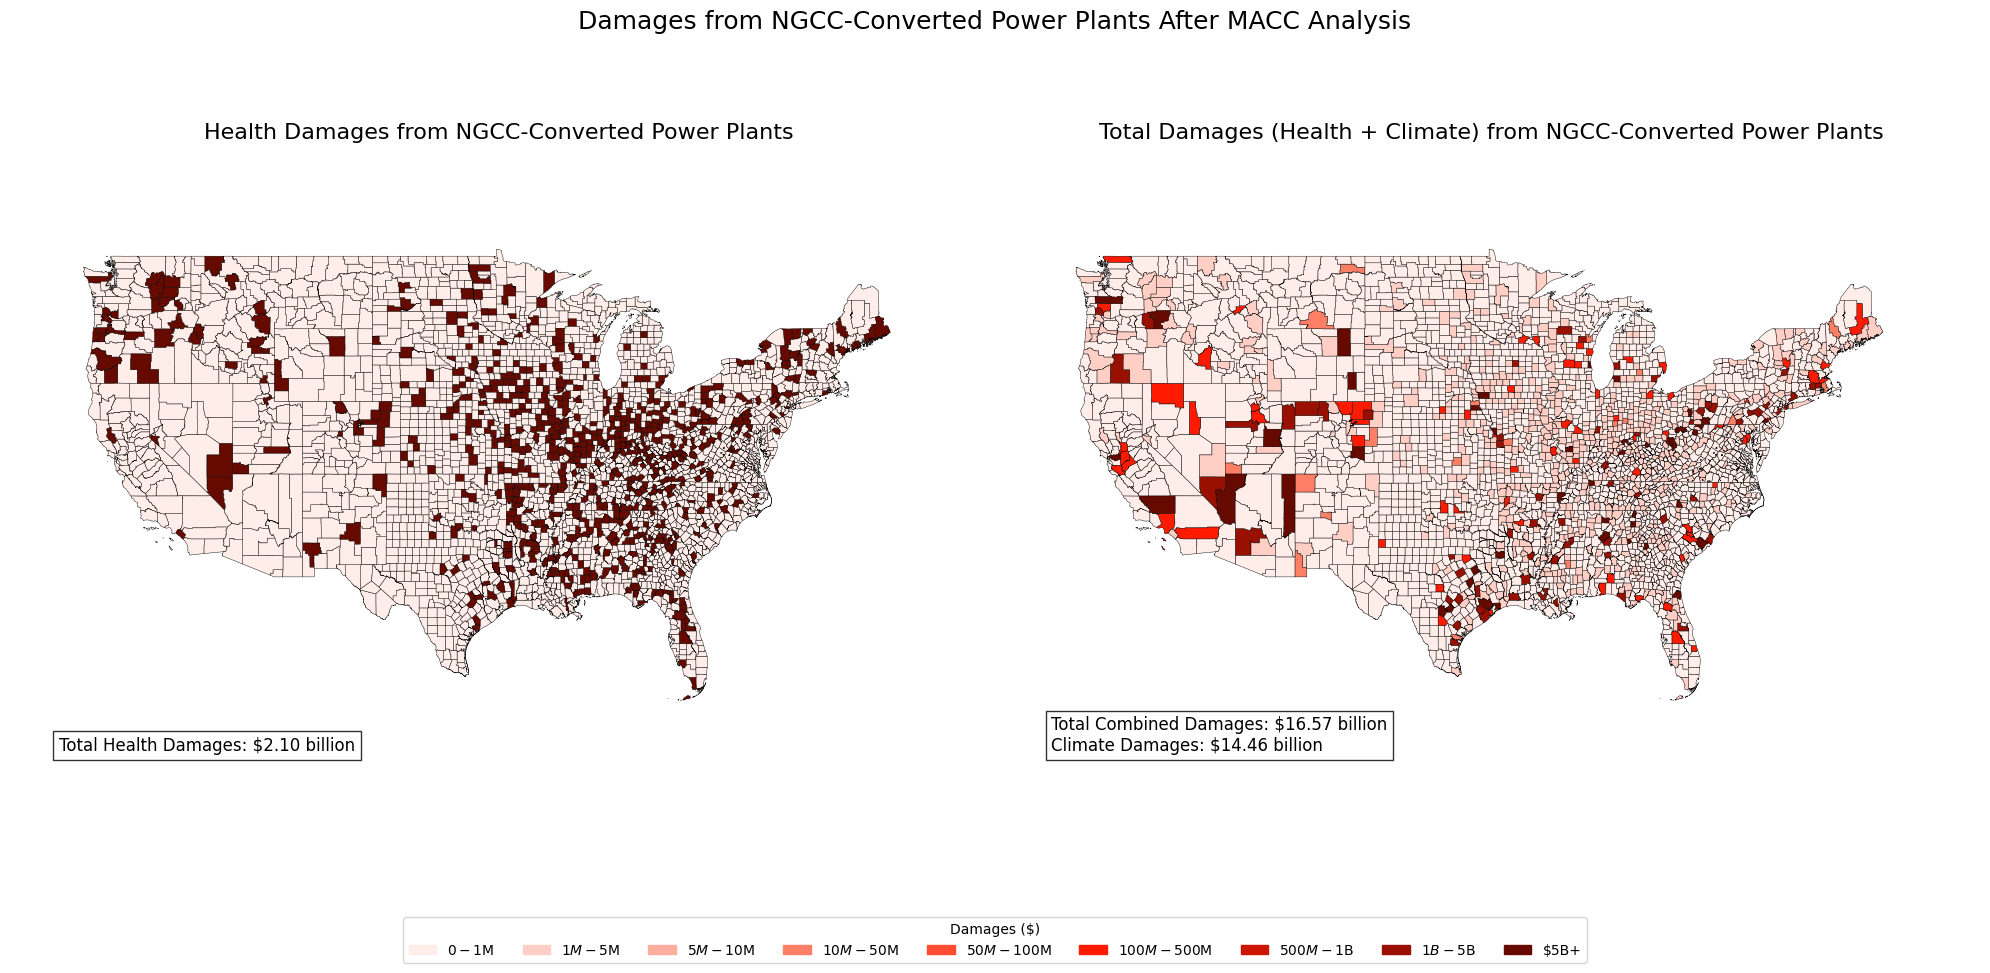

Visualization complete!


In [14]:
# ================================
# Step 3: Load county boundaries and join with results
# ================================

# Load county boundaries
county_path = os.path.join(project_root, 'data', 'raw', 'cb_2018_us_county_500k', 'cb_2018_us_county_500k.shp')
us_counties = gpd.read_file(county_path)

# Convert all datasets to the same CRS
target_crs = "epsg:4269"  # NAD83, commonly used for US data
resultsISRM = resultsISRM.to_crs(target_crs)
us_counties = us_counties.to_crs(target_crs)
ngcc_full_data = ngcc_full_data.to_crs(target_crs)

# Perform spatial join to assign each grid cell to a county
print("Joining health impacts to counties...")
results_county = resultsISRM.sjoin(us_counties, how="left", predicate="intersects")

# Aggregate health impacts by county
county_summary = results_county.groupby("NAME").agg({
    "SOA": "sum",
    "pNO3": "sum",
    "pNH4": "sum",
    "pSO4": "sum",
    "PrimaryPM25": "sum",
    "TotalPM25": "sum",
    "deathsK": "sum",
    "deathsL": "sum"
}).reset_index()

# Merge summary with county shapefile for visualization
us_counties = us_counties.merge(county_summary, on="NAME", how="left")

# Exclude Alaska, Hawaii, and Puerto Rico
us_counties = us_counties[~us_counties['STATEFP'].isin(["02", "15", "72"])]

# ================================
# Step 4: Calculate damages
# ================================

# Value of a Statistical Life in dollars
VSL = 13.2e6  # $13.2 million per life

# Calculate health damages for each county
us_counties['HealthDamages'] = us_counties['deathsK'] * VSL
us_counties['HealthDamages'] = us_counties['HealthDamages'].fillna(0)

# Spatial join to assign facilities to counties
facility_counties = ngcc_full_data.sjoin(us_counties[['GEOID', 'geometry']], how="inner", predicate="within")

# Social Cost of Carbon (SCC) in dollars per metric tonne
SCC = 51  # $51 per tonne of CO2 (based on EPA estimates)

# Calculate climate damages using CO2 values from the MACC output
facility_counties['ClimateDamages'] = facility_counties['CO2'] * SCC

# Aggregate climate damages by county
climate_summary = facility_counties.groupby('GEOID')['ClimateDamages'].sum().reset_index()
print(f"Calculated climate damages for {len(climate_summary)} counties")

# Merge climate damages with county data
us_counties = us_counties.merge(climate_summary[['GEOID', 'ClimateDamages']], on='GEOID', how='left')
us_counties['ClimateDamages'] = us_counties['ClimateDamages'].fillna(0)

# Calculate total damages (health + climate)
us_counties['TotalDamages'] = us_counties['HealthDamages'] + us_counties['ClimateDamages']

# ================================
# Step 5: Create visualization
# ================================

# Define bins and colors for damages
bins = [0, 1e6, 5e6, 10e6, 50e6, 100e6, 500e6, 1e9, 5e9, float("inf")]
colors = ['#ffedea', '#ffcec5', '#ffad9f', '#ff7f66', '#ff4d33', 
          '#ff1a00', '#cc1600', '#990f00', '#660a00']

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Bin the health and total damages data
us_counties['HealthDamages_Binned'] = pd.cut(us_counties['HealthDamages'], bins=bins, labels=False, include_lowest=True)
us_counties['TotalDamages_Binned'] = pd.cut(us_counties['TotalDamages'], bins=bins, labels=False, include_lowest=True)

# Create figure with two panels
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Left panel - Health Damages
ax1 = plt.subplot(gs[0])
us_counties.plot(column='HealthDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax1, legend=False)
ax1.set_title('Health Damages from NGCC-Converted Power Plants', fontsize=16)
ax1.axis('off')
ax1.set_aspect(1.3)
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)

# Calculate total damages across all counties
total_health = us_counties['HealthDamages'].sum() / 1e9  # billions of dollars
total_climate = us_counties['ClimateDamages'].sum() / 1e9  # billions of dollars
total_combined = us_counties['TotalDamages'].sum() / 1e9  # billions of dollars

# Add text annotation with total health damages
ax1.text(0.05, 0.05, f'Total Health Damages: ${total_health:.2f} billion', 
         transform=ax1.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Right panel - Total Damages (Health + Climate)
ax2 = plt.subplot(gs[1])
us_counties.plot(column='TotalDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax2, legend=False)
ax2.set_title('Total Damages (Health + Climate) from NGCC-Converted Power Plants', fontsize=16)
ax2.axis('off')
ax2.set_aspect(1.3)
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)

# Add text annotation with total combined damages
ax2.text(0.05, 0.05, 
         f'Total Combined Damages: ${total_combined:.2f} billion\n' +
         f'Climate Damages: ${total_climate:.2f} billion', 
         transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Create formatted legend labels
legend_labels = [
    '$0 - $1M', 
    '$1M - $5M', 
    '$5M - $10M', 
    '$10M - $50M', 
    '$50M - $100M', 
    '$100M - $500M', 
    '$500M - $1B', 
    '$1B - $5B', 
    '$5B+'
]

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color=colors[i], label=legend_labels[i]) 
    for i in range(len(legend_labels))
]

# Add the custom legend to the figure
fig.legend(handles=legend_patches, title="Damages ($)", 
           loc="lower center", ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.02))

# Adjust layout
plt.tight_layout(rect=[0, 0.07, 1, 0.98])
plt.suptitle('Damages from NGCC-Converted Power Plants After MACC Analysis', fontsize=18, y=0.98)

# Save the figure
plt.savefig(os.path.join(figure_dir, "ngcc_health_climate_damages.png"), dpi=300, bbox_inches='tight')

plt.show()

print("Visualization complete!")

Calculated climate damages for 251 counties
Health damages distribution:
count    3.121000e+03
mean     6.741623e+05
std      8.812507e+05
min      1.397188e+05
25%      1.397188e+05
50%      2.794376e+05
75%      8.383129e+05
max      4.331283e+06
Name: HealthDamages, dtype: float64
Maximum health damages in a single county: $4.33 million
Maximum climate damages in a single county: $403.39 million
Maximum total damages in a single county: $403.67 million
Total Health Damages: $2.10 billion
Total Climate Damages: $14.46 billion
Total Combined Damages: $16.57 billion


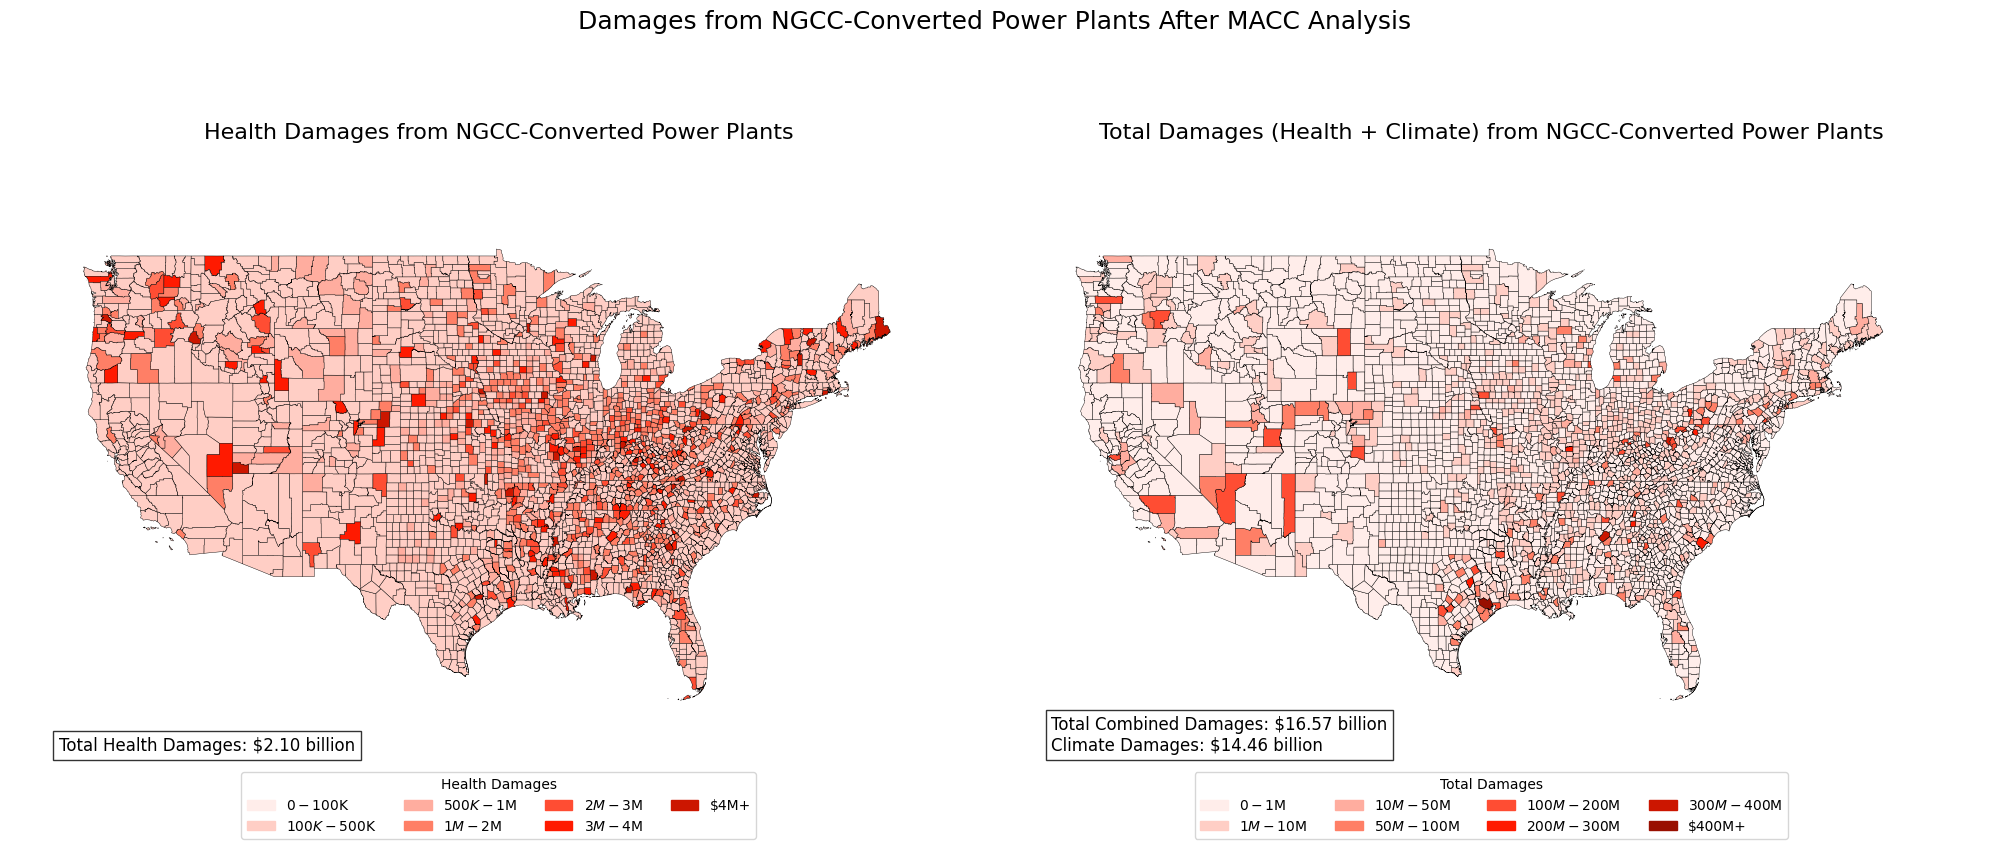

Visualization complete!


In [25]:
# Load county boundaries
county_path = os.path.join(project_root, 'data', 'raw', 'cb_2018_us_county_500k', 'cb_2018_us_county_500k.shp')
us_counties = gpd.read_file(county_path)

# Convert all datasets to the same CRS
target_crs = "epsg:4269"  # NAD83, commonly used for US data
us_counties = us_counties.to_crs(target_crs)

# Merge summary with county shapefile for visualization
us_counties = us_counties.merge(county_summary, on="NAME", how="left")

# Exclude Alaska, Hawaii, and Puerto Rico
us_counties = us_counties[~us_counties['STATEFP'].isin(["02", "15", "72"])]

# ================================
# Step 4: Calculate damages
# ================================

# Value of a Statistical Life in dollars
VSL = 13.2e6  # $13.2 million per life

# Calculate health damages for each county
us_counties['HealthDamages'] = us_counties['deathsK'] * VSL
us_counties['HealthDamages'] = us_counties['HealthDamages'].fillna(0)

# Spatial join to assign facilities to counties
facility_counties = ngcc_full_data.sjoin(us_counties[['GEOID', 'geometry']], how="inner", predicate="within")

# Social Cost of Carbon (SCC) in dollars per metric tonne
SCC = 51  # $51 per tonne of CO2 (based on EPA estimates)

# Calculate climate damages using CO2 values from the MACC output
facility_counties['ClimateDamages'] = facility_counties['CO2'] * SCC

# Aggregate climate damages by county
climate_summary = facility_counties.groupby('GEOID')['ClimateDamages'].sum().reset_index()
print(f"Calculated climate damages for {len(climate_summary)} counties")

# Merge climate damages with county data
us_counties = us_counties.merge(climate_summary[['GEOID', 'ClimateDamages']], on='GEOID', how='left')
us_counties['ClimateDamages'] = us_counties['ClimateDamages'].fillna(0)

# Calculate total damages (health + climate)
us_counties['TotalDamages'] = us_counties['HealthDamages'] + us_counties['ClimateDamages']

# ================================
# Step 5: View damage distribution statistics
# ================================

# Print statistics on the damage distributions
print("Health damages distribution:")
print(us_counties['HealthDamages'].describe())

health_max = us_counties['HealthDamages'].max()
climate_max = us_counties['ClimateDamages'].max()
total_max = us_counties['TotalDamages'].max()

print(f"Maximum health damages in a single county: ${health_max/1e6:.2f} million")
print(f"Maximum climate damages in a single county: ${climate_max/1e6:.2f} million")
print(f"Maximum total damages in a single county: ${total_max/1e6:.2f} million")

# ================================
# Step 6: Create fixed bins for visualization
# ================================

# Create manual bins for health damages (based on actual distribution)
health_bins = [
    0, 
    100000,    # $100K
    500000,    # $500K
    1000000,   # $1M
    2000000,   # $2M
    3000000,   # $3M
    4000000,   # $4M
    5000000    # $5M (slightly above max)
]

# Create manual bins for total damages (based on actual distribution)
total_bins = [
    0,
    1000000,     # $1M
    10000000,    # $10M
    50000000,    # $50M
    100000000,   # $100M
    200000000,   # $200M
    300000000,   # $300M
    400000000,   # $400M
    500000000    # $500M (slightly above max)
]

# Format labels for readability
health_labels = [
    "$0-$100K", 
    "$100K-$500K", 
    "$500K-$1M", 
    "$1M-$2M", 
    "$2M-$3M", 
    "$3M-$4M", 
    "$4M+"
]

total_labels = [
    "$0-$1M", 
    "$1M-$10M", 
    "$10M-$50M", 
    "$50M-$100M", 
    "$100M-$200M", 
    "$200M-$300M", 
    "$300M-$400M", 
    "$400M+"
]

# Create colors (should be enough for the maximum number of bins)
colors = ['#ffedea', '#ffcec5', '#ffad9f', '#ff7f66', '#ff4d33', '#ff1a00', '#cc1600', '#990f00', '#660a00']

# Create discrete colormaps for each panel
cmap_health = mcolors.ListedColormap(colors[:len(health_labels)])
cmap_total = mcolors.ListedColormap(colors[:len(total_labels)])

# Bin the health and total damages data
us_counties['HealthDamages_Binned'] = pd.cut(
    us_counties['HealthDamages'], 
    bins=health_bins, 
    labels=range(len(health_bins)-1), 
    include_lowest=True,
    duplicates='drop'
)

us_counties['TotalDamages_Binned'] = pd.cut(
    us_counties['TotalDamages'], 
    bins=total_bins, 
    labels=range(len(total_bins)-1), 
    include_lowest=True,
    duplicates='drop'
)

# ================================
# Step 7: Create visualization
# ================================

# Create figure with two panels
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Left panel - Health Damages
ax1 = plt.subplot(gs[0])
us_counties.plot(column='HealthDamages_Binned', cmap=cmap_health, linewidth=0.3, edgecolor="black", 
                 ax=ax1, legend=False)
ax1.set_title('Health Damages from NGCC-Converted Power Plants', fontsize=16)
ax1.axis('off')
ax1.set_aspect(1.3)
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)

# Calculate total damages across all counties
total_health = us_counties['HealthDamages'].sum() / 1e9  # billions of dollars
total_climate = us_counties['ClimateDamages'].sum() / 1e9  # billions of dollars
total_combined = us_counties['TotalDamages'].sum() / 1e9  # billions of dollars

# Add text annotation with total health damages
ax1.text(0.05, 0.05, f'Total Health Damages: ${total_health:.2f} billion', 
         transform=ax1.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Right panel - Total Damages (Health + Climate)
ax2 = plt.subplot(gs[1])
us_counties.plot(column='TotalDamages_Binned', cmap=cmap_total, linewidth=0.3, edgecolor="black", 
                 ax=ax2, legend=False)
ax2.set_title('Total Damages (Health + Climate) from NGCC-Converted Power Plants', fontsize=16)
ax2.axis('off')
ax2.set_aspect(1.3)
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)

# Add text annotation with total combined damages
ax2.text(0.05, 0.05, 
         f'Total Combined Damages: ${total_combined:.2f} billion\n' +
         f'Climate Damages: ${total_climate:.2f} billion', 
         transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Create custom legend patches for health damages
health_legend_patches = [
    mpatches.Patch(color=colors[i], label=health_labels[i]) 
    for i in range(len(health_labels))
]

# Create custom legend patches for total damages
total_legend_patches = [
    mpatches.Patch(color=colors[i], label=total_labels[i]) 
    for i in range(len(total_labels))
]

# Add legends for each panel
legend1 = ax1.legend(handles=health_legend_patches, title="Health Damages", 
          loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10)

legend2 = ax2.legend(handles=total_legend_patches, title="Total Damages", 
          loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10)

# Adjust layout with room for the legends
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.suptitle('Damages from NGCC-Converted Power Plants After MACC Analysis', fontsize=18, y=0.98)

# Save the figure
plt.savefig(os.path.join(figure_dir, "ngcc_health_climate_damages.png"), dpi=300, bbox_inches='tight')

# Display totals
print(f"Total Health Damages: ${total_health:.2f} billion")
print(f"Total Climate Damages: ${total_climate:.2f} billion")
print(f"Total Combined Damages: ${total_combined:.2f} billion")

plt.show()

print("Visualization complete!")

## Replacements with CCS only

Create and display the MACC curve for the baseline scenario.

2025-03-07 02:49:58,318 - macc_analysis - INFO - Running MACC analysis with CCS scenario: ccs_scenario
2025-03-07 02:49:58,322 - macc_analysis - INFO - Loaded emissions data with 1343 records
2025-03-07 02:49:58,325 - macc_analysis - INFO - Found 1121 unique facilities in emissions data
2025-03-07 02:50:07,747 - macc_analysis - INFO - Loaded plant data with 26011 records
2025-03-07 02:50:07,769 - macc_analysis - INFO - Filtered to 4092 plant records
/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_level_attributes.rename(columns={'Plant Code': 'Facility ID'}, inplace=True)
2025-03-07 02:50:08,007 - macc_analysis - INFO - Loaded capital cost data with 108 records
/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:314: SettingWithCopyW

CCS Scenario - Total CO2 emissions analyzed: 1.32 Gt
CCS Scenario - Emissions with negative abatement cost: 0.49 Gt (37.5%)
CCS Scenario - Number of facilities analyzed: 907


2025-03-07 02:50:20,178 - macc_analysis - INFO - MACC curve for CCS scenario saved to /Users/dhruvsuri/Code/US-macc/output/baseline/macc_curve_ccs.png


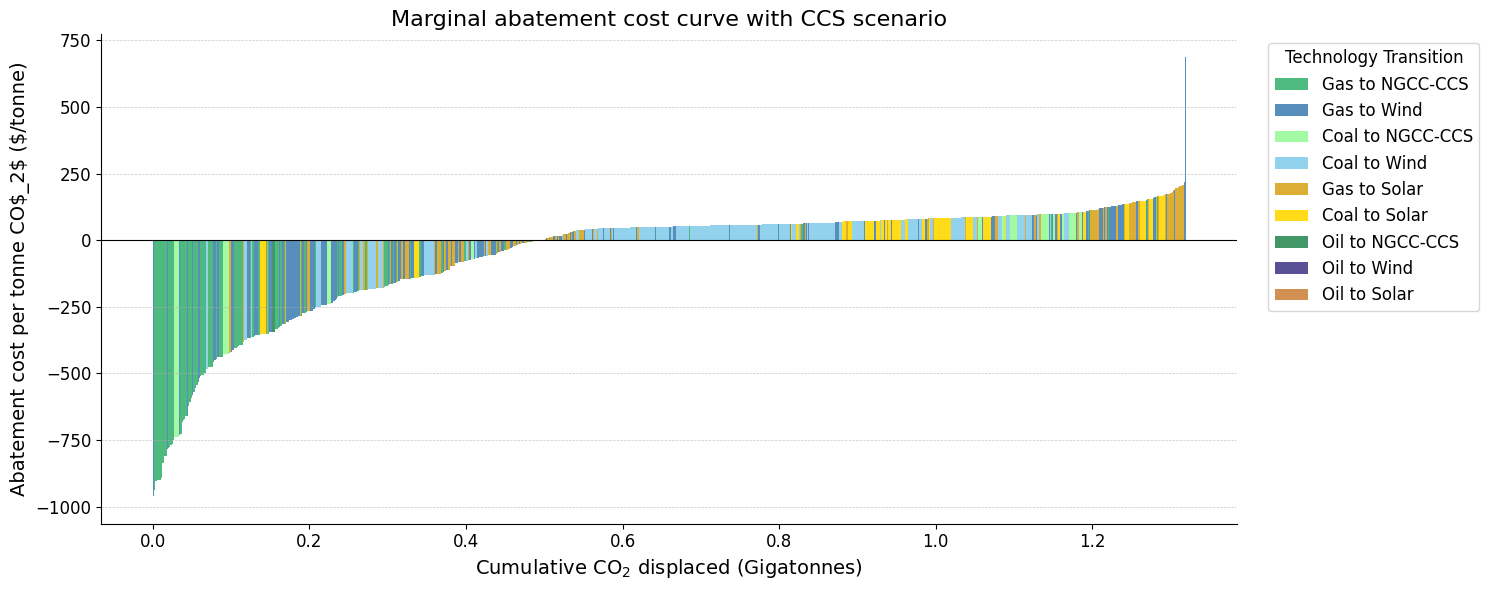

<Figure size 1500x600 with 0 Axes>

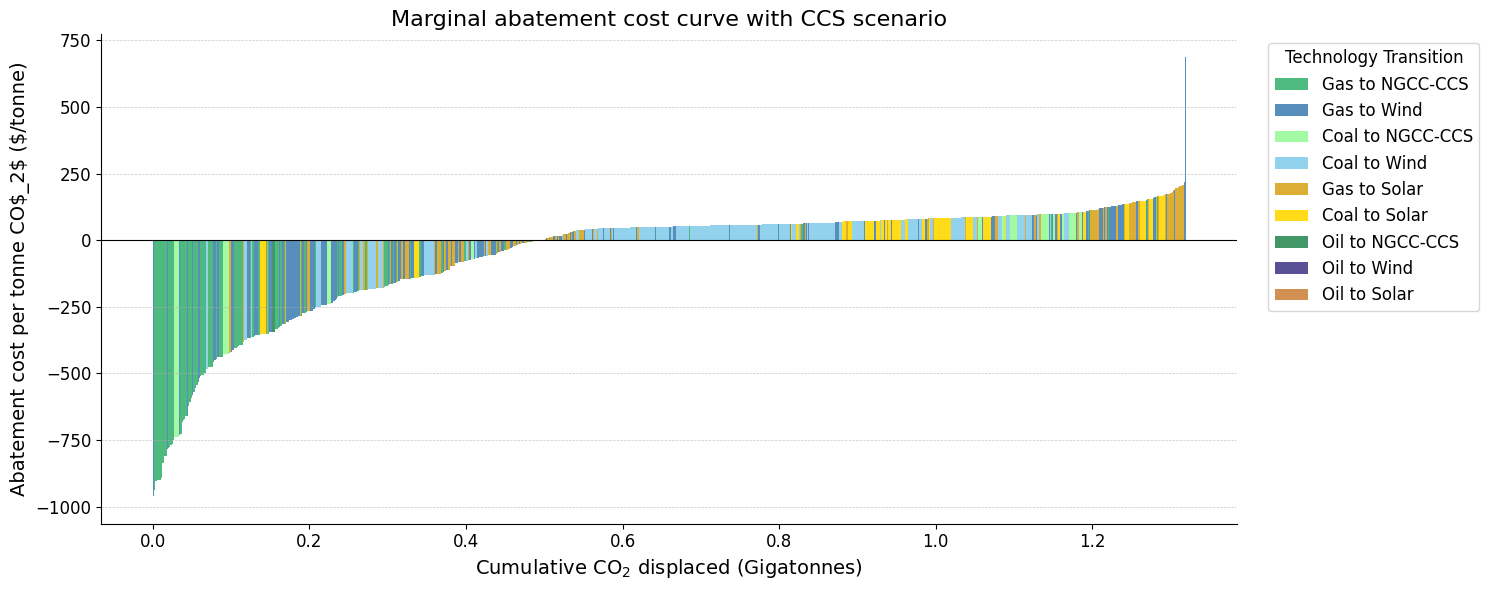

In [27]:
# Run the CCS scenario
ccs_merged_df, ccs_macc_data, ccs_summary = macc.run_ccs_scenario(config, 'ccs_scenario')

# Display summary results
print(f"CCS Scenario - Total CO2 emissions analyzed: {ccs_summary['total_emissions_gt']:.2f} Gt")
print(f"CCS Scenario - Emissions with negative abatement cost: {ccs_summary['negative_cost_emissions_gt']:.2f} Gt ({ccs_summary['negative_cost_percentage']:.1f}%)")
print(f"CCS Scenario - Number of facilities analyzed: {ccs_summary['facility_count']}")

# Show the CCS MACC curve
plt.figure(figsize=(15, 6))
fig = macc.plot_macc_curve_with_ccs(ccs_macc_data, config)
plt.show()

In [31]:
ccs_macc_data

facility_id        macc     emissions       transition from_fuel  \
13           147 -980.749524  4.324476e+05  Gas to NGCC-CCS       Gas   
412         7836 -978.788410  1.217366e+05  Gas to NGCC-CCS       Gas   
856        57943 -960.572054  5.942801e+05      Gas to Wind       Gas   
637        55247 -956.077486  1.787695e+05  Gas to NGCC-CCS       Gas   
674        55372 -938.681374  8.223936e+05  Gas to NGCC-CCS       Gas   
..           ...         ...           ...              ...       ...   
295         6042  208.226500  2.420349e+06     Gas to Solar       Gas   
395         7605  217.572239  6.995313e+05      Gas to Wind       Gas   
220         3176  222.598468  2.620497e+05     Gas to Solar       Gas   
469         8906  228.509879  4.874854e+05      Gas to Wind       Gas   
203         3006  689.484966  7.997213e+04      Gas to Wind       Gas   

      to_tech  nameplate_capacity  annual_generation  cumulative_end  \
13   NGCC-CCS               573.7         1285009.72    4.324476e+05   
412  NGCC-CCS               513.3          220893.69    5.541842e+05   
856      Wind               363.0         1171055.83    1.148464e+06   
637  NGCC-CCS               564.0          566005.76    1.327234e+06   
674  NGCC-CCS              1277.1         1492805.65    2.149627e+06   
..        ...                 ...                ...             ...   
295     Solar              2951.2         6747495.01    1.317482e+09   
395      Wind               248.0         1859457.55    1.318181e+09   
220     Solar               145.9          625646.86    1.318443e+09   
469      Wind              1345.0         1544242.55    1.318931e+09   
203      Wind               534.9         1101809.93    1.319011e+09   

     cumulative_start  
13       0.000000e+00  
412      4.324476e+05  
856      5.541842e+05  
637      1.148464e+06  
674      1.327234e+06  
..                ...  
295      1.315061e+09  
395      1.317482e+09  
220      1.318181e+09  
469      1.318443e+09  
203      1.318931e+09  

[907 rows x 10 columns]

In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.gridspec as gridspec
from pathlib import Path

# Make sure the scripts directory is in the path
project_root = os.path.dirname(os.getcwd())
scripts_dir = os.path.join(project_root, 'scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

# Import the emissions processing module and run_sr function
from macc_to_emissions import process_macc_results_for_emissions, prepare_inmap_input

# Define paths and create directories if they don't exist
ccs_output_dir = os.path.join(project_root, 'output', 'ccs_scenario')
ccs_air_pollution_dir = os.path.join(project_root, 'output', 'ccs_air_pollution')
figure_dir = os.path.join(project_root, 'figures')

# Create all required directories
os.makedirs(ccs_output_dir, exist_ok=True)
os.makedirs(ccs_air_pollution_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

print(f"Created output directories")

# 1. Save the CCS MACC data and merged_df for potential future use
ccs_macc_data.to_csv(os.path.join(ccs_output_dir, 'ccs_macc_curve_data.csv'), index=False)
ccs_merged_df.to_csv(os.path.join(ccs_output_dir, 'ccs_macc_calculations.csv'), index=False)
print(f"Saved CCS MACC data to {ccs_output_dir}")

# 2. Process CCS MACC results for air pollution analysis
print("Processing CCS scenario for air pollution analysis...")

# Temporary fix: Modify a copy of the CCS MACC data to work with our existing function
ccs_macc_copy = ccs_macc_data.copy()

# Check what conversion types are in the data
print("Conversion types in CCS MACC data:")
print(ccs_macc_copy['to_tech'].value_counts())

# For the process_macc_results_for_emissions function, we need to modify NGCC-CCS to NGCC
# This is a temporary workaround so we can use the same function
if 'to_tech' in ccs_macc_copy.columns and 'NGCC-CCS' in ccs_macc_copy['to_tech'].values:
    print("Temporarily converting 'NGCC-CCS' to 'NGCC' for processing")
    ccs_macc_copy.loc[ccs_macc_copy['to_tech'] == 'NGCC-CCS', 'to_tech'] = 'NGCC'
    
    # Also update transition column if it exists
    if 'transition' in ccs_macc_copy.columns:
        ccs_macc_copy['transition'] = ccs_macc_copy['transition'].str.replace('NGCC-CCS', 'NGCC')

# Now process with the modified data
ccs_gdf = process_macc_results_for_emissions(ccs_macc_copy, ccs_merged_df, ccs_air_pollution_dir)

2025-03-07 03:26:32,356 - pyogrio._io - INFO - Created 158 records


InMAP input file saved to /Users/dhruvsuri/Code/US-macc/output/ccs_air_pollution/ngcc_converted_for_inmap.gpkg
Running Source-Receptor model with CCS-converted plants...
Loaded 158 CCS-converted plants for analysis
Making polygons as geometry.
Finished joining dataframes. Missing locations: 0
SOA data allocated.
pNO3 data allocated.
pNH4 data allocated.
pSO4 data allocated.
PrimaryPM25 data allocated.
Accessing data.
Finished (337 seconds)
Setting CRS for resultsISRM to EPSG:4269
Joining health impacts to counties...
Calculated climate damages for 137 counties
Health damages distribution:
count      3121.000000
mean     123487.811584
std      161427.951811
min       24494.509875
25%       25593.396267
50%       51186.792534
75%      153560.377602
max      793395.284278
Name: HealthDamages, dtype: float64
Maximum health damages in a single county: $0.79 million
Maximum climate damages in a single county: $340.92 million
Maximum total damages in a single county: $340.94 million
Health bi

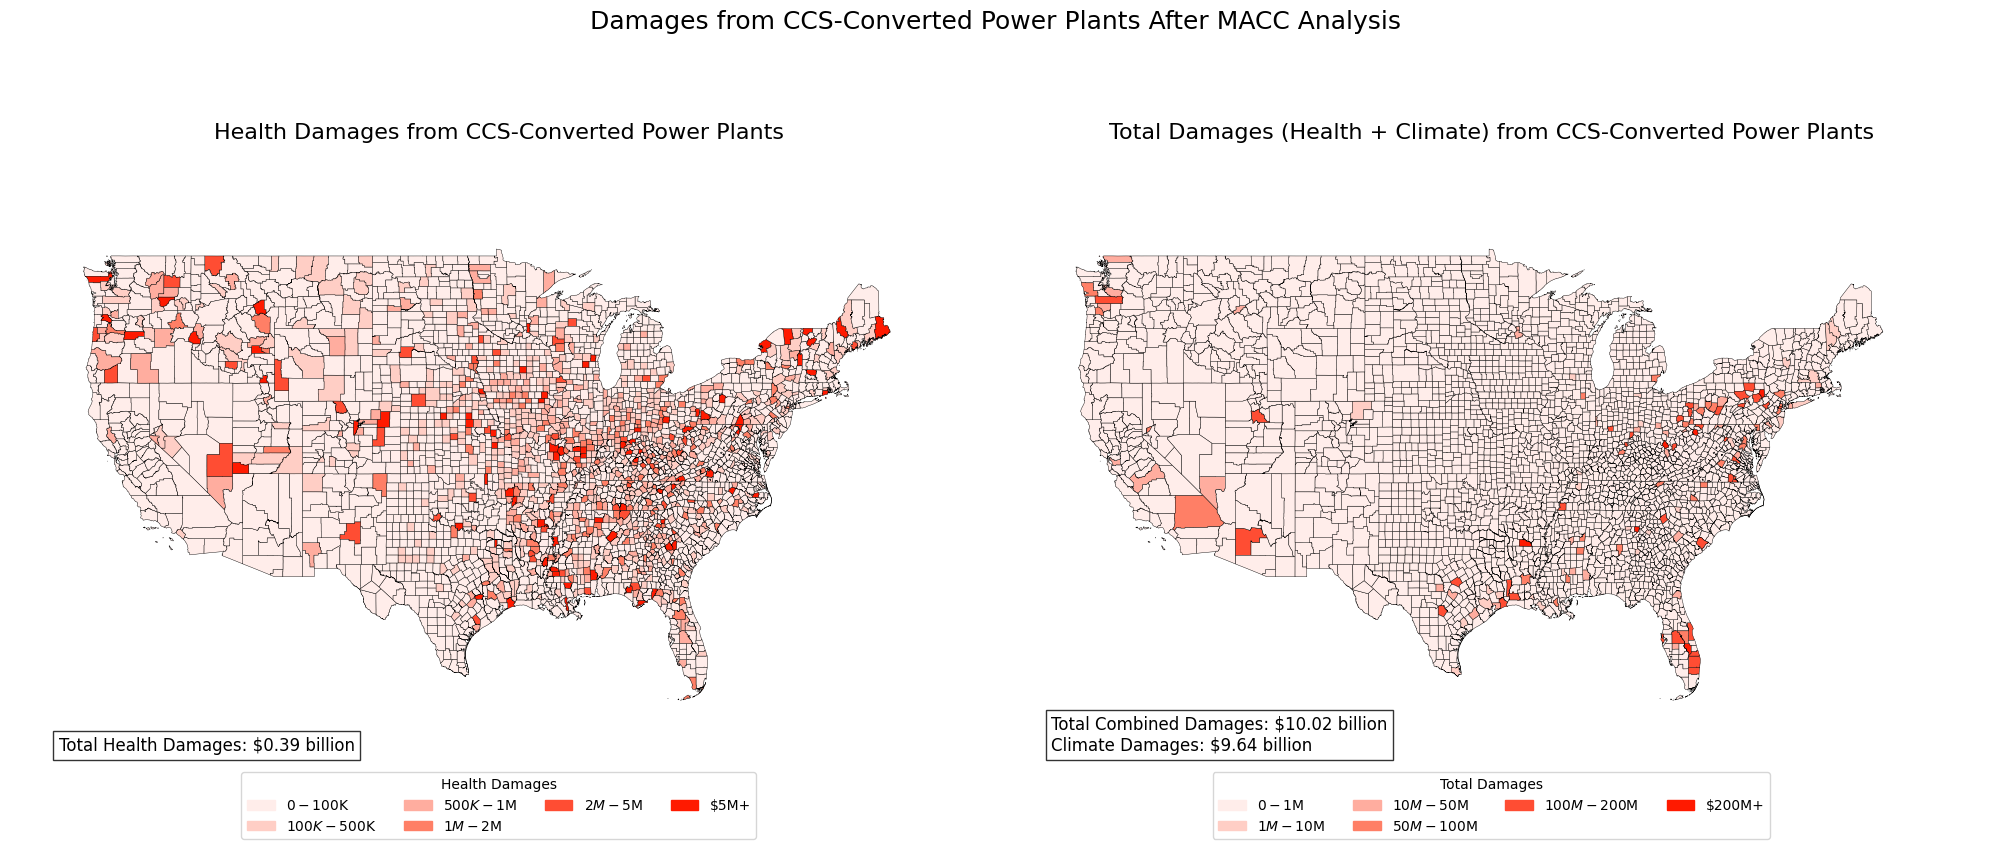

CCS scenario visualization complete!


In [34]:
if ccs_gdf is not None:
    # 3. Prepare InMAP input file
    ccs_inmap_path = prepare_inmap_input(ccs_gdf, ccs_air_pollution_dir)
    
    # 4. Run the Source-Receptor model with the CCS-converted plants
    print("Running Source-Receptor model with CCS-converted plants...")
    
    # Load the InMAP-formatted emissions data
    ccs_inmap = gpd.read_file(ccs_inmap_path)
    print(f"Loaded {len(ccs_inmap)} CCS-converted plants for analysis")
    
    # Run the SR model
    resultsISRM = run_sr(ccs_inmap, model="isrm", emis_units="tons/year")
    
    # Explicitly set CRS for resultsISRM if it's not defined
    if resultsISRM.crs is None:
        print("Setting CRS for resultsISRM to EPSG:4269")
        resultsISRM = resultsISRM.set_crs("epsg:4269", allow_override=True)
    
    # 5. Load county boundaries and join with results
    county_path = os.path.join(project_root, 'data', 'raw', 'cb_2018_us_county_500k', 'cb_2018_us_county_500k.shp')
    us_counties = gpd.read_file(county_path)
    
    # Convert all datasets to the same CRS
    target_crs = "epsg:4269"  # NAD83, commonly used for US data
    resultsISRM = resultsISRM.to_crs(target_crs)
    us_counties = us_counties.to_crs(target_crs)
    ccs_gdf = ccs_gdf.to_crs(target_crs)
    
    # Perform spatial join to assign each grid cell to a county
    print("Joining health impacts to counties...")
    results_county = resultsISRM.sjoin(us_counties, how="left", predicate="intersects")
    
    # Aggregate health impacts by county
    county_summary = results_county.groupby("NAME").agg({
        "SOA": "sum",
        "pNO3": "sum",
        "pNH4": "sum",
        "pSO4": "sum",
        "PrimaryPM25": "sum",
        "TotalPM25": "sum",
        "deathsK": "sum",
        "deathsL": "sum"
    }).reset_index()
    
    # Merge summary with county shapefile for visualization
    us_counties = us_counties.merge(county_summary, on="NAME", how="left")
    
    # Exclude Alaska, Hawaii, and Puerto Rico
    us_counties = us_counties[~us_counties['STATEFP'].isin(["02", "15", "72"])]
    
    # 6. Calculate damages
    # Value of a Statistical Life in dollars
    VSL = 13.2e6  # $13.2 million per life
    
    # Calculate health damages for each county
    us_counties['HealthDamages'] = us_counties['deathsK'] * VSL
    us_counties['HealthDamages'] = us_counties['HealthDamages'].fillna(0)
    
    # Spatial join to assign facilities to counties
    facility_counties = ccs_gdf.sjoin(us_counties[['GEOID', 'geometry']], how="inner", predicate="within")
    
    # Social Cost of Carbon (SCC) in dollars per metric tonne
    SCC = 51  # $51 per tonne of CO2 (based on EPA estimates)
    
    # Calculate climate damages using CO2 values from the MACC output
    facility_counties['ClimateDamages'] = facility_counties['CO2'] * SCC
    
    # Aggregate climate damages by county
    climate_summary = facility_counties.groupby('GEOID')['ClimateDamages'].sum().reset_index()
    print(f"Calculated climate damages for {len(climate_summary)} counties")
    
    # Merge climate damages with county data
    us_counties = us_counties.merge(climate_summary[['GEOID', 'ClimateDamages']], on='GEOID', how='left')
    us_counties['ClimateDamages'] = us_counties['ClimateDamages'].fillna(0)
    
    # Calculate total damages (health + climate)
    us_counties['TotalDamages'] = us_counties['HealthDamages'] + us_counties['ClimateDamages']
    
    # 7. View damage distribution statistics
    print("Health damages distribution:")
    print(us_counties['HealthDamages'].describe())
    
    health_max = us_counties['HealthDamages'].max()
    climate_max = us_counties['ClimateDamages'].max()
    total_max = us_counties['TotalDamages'].max()
    
    print(f"Maximum health damages in a single county: ${health_max/1e6:.2f} million")
    print(f"Maximum climate damages in a single county: ${climate_max/1e6:.2f} million")
    print(f"Maximum total damages in a single county: ${total_max/1e6:.2f} million")
    
    # 8. Create fixed bins for visualization based on the data
    # Create manual bins that fit the actual CCS data distribution
    # These will be adjusted based on the actual data
    # Create fixed bins with explicit float conversion
    health_bins = [
        0.0, 
        float(100000),
        float(min(500000, health_max/6*2)),
        float(min(1000000, health_max/6*3)),
        float(min(2000000, health_max/6*4)), 
        float(min(5000000, health_max/6*5)),
        float(health_max * 1.1)
    ]

    total_bins = [
        0.0,
        float(1000000),
        float(10000000),
        float(50000000),
        float(100000000),
        float(200000000),
        float(total_max * 1.1)
    ]

    # Make sure the bins are strictly increasing
    health_bins = sorted(list(set(health_bins)))
    total_bins = sorted(list(set(total_bins)))

    print("Health bins:", health_bins)
    print("Total bins:", total_bins)

    # Update labels to match the number of bins
    health_labels = [
        "$0-$100K", 
        "$100K-$500K", 
        "$500K-$1M", 
        "$1M-$2M", 
        "$2M-$5M", 
        "$5M+"
    ][:len(health_bins)-1]  # Make sure labels match number of bins

    total_labels = [
        "$0-$1M", 
        "$1M-$10M", 
        "$10M-$50M", 
        "$50M-$100M", 
        "$100M-$200M", 
        "$200M+"
    ][:len(total_bins)-1]  # Make sure labels match number of bins
    
    # Create colors (should be enough for the maximum number of bins)
    colors = ['#ffedea', '#ffcec5', '#ffad9f', '#ff7f66', '#ff4d33', '#ff1a00', '#cc1600', '#990f00']
    
    # Create discrete colormaps for each panel
    cmap_health = mcolors.ListedColormap(colors[:len(health_labels)])
    cmap_total = mcolors.ListedColormap(colors[:len(total_labels)])
    
    # Bin the health and total damages data
    us_counties['HealthDamages_Binned'] = pd.cut(
        us_counties['HealthDamages'], 
        bins=health_bins, 
        labels=range(len(health_bins)-1), 
        include_lowest=True,
        duplicates='drop'
    )
    
    us_counties['TotalDamages_Binned'] = pd.cut(
        us_counties['TotalDamages'], 
        bins=total_bins, 
        labels=range(len(total_bins)-1), 
        include_lowest=True,
        duplicates='drop'
    )
    
    # 9. Create visualization
    # Create figure with two panels
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    
    # Left panel - Health Damages
    ax1 = plt.subplot(gs[0])
    us_counties.plot(column='HealthDamages_Binned', cmap=cmap_health, linewidth=0.3, edgecolor="black", 
                     ax=ax1, legend=False)
    ax1.set_title('Health Damages from CCS-Converted Power Plants', fontsize=16)
    ax1.axis('off')
    ax1.set_aspect(1.3)
    ax1.set_xlim(-130, -60)
    ax1.set_ylim(20, 55)
    
    # Calculate total damages across all counties
    total_health = us_counties['HealthDamages'].sum() / 1e9  # billions of dollars
    total_climate = us_counties['ClimateDamages'].sum() / 1e9  # billions of dollars
    total_combined = us_counties['TotalDamages'].sum() / 1e9  # billions of dollars
    
    # Add text annotation with total health damages
    ax1.text(0.05, 0.05, f'Total Health Damages: ${total_health:.2f} billion', 
             transform=ax1.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    # Right panel - Total Damages (Health + Climate)
    ax2 = plt.subplot(gs[1])
    us_counties.plot(column='TotalDamages_Binned', cmap=cmap_total, linewidth=0.3, edgecolor="black", 
                     ax=ax2, legend=False)
    ax2.set_title('Total Damages (Health + Climate) from CCS-Converted Power Plants', fontsize=16)
    ax2.axis('off')
    ax2.set_aspect(1.3)
    ax2.set_xlim(-130, -60)
    ax2.set_ylim(20, 55)
    
    # Add text annotation with total combined damages
    ax2.text(0.05, 0.05, 
             f'Total Combined Damages: ${total_combined:.2f} billion\n' +
             f'Climate Damages: ${total_climate:.2f} billion', 
             transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    # Create custom legend patches for health damages
    health_legend_patches = [
        mpatches.Patch(color=colors[i], label=health_labels[i]) 
        for i in range(len(health_labels))
    ]
    
    # Create custom legend patches for total damages
    total_legend_patches = [
        mpatches.Patch(color=colors[i], label=total_labels[i]) 
        for i in range(len(total_labels))
    ]
    
    # Add legends for each panel
    legend1 = ax1.legend(handles=health_legend_patches, title="Health Damages", 
              loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10)
    
    legend2 = ax2.legend(handles=total_legend_patches, title="Total Damages", 
              loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10)
    
    # Adjust layout with room for the legends
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.suptitle('Damages from CCS-Converted Power Plants After MACC Analysis', fontsize=18, y=0.98)
    
    # Save the figure
    plt.savefig(os.path.join(figure_dir, "ccs_health_climate_damages.png"), dpi=300, bbox_inches='tight')
    
    # Display totals
    print(f"Total Health Damages: ${total_health:.2f} billion")
    print(f"Total Climate Damages: ${total_climate:.2f} billion")
    print(f"Total Combined Damages: ${total_combined:.2f} billion")
    
    plt.show()
    
    print("CCS scenario visualization complete!")
else:
    print("Error: Could not process CCS scenario data for air pollution analysis")

/Users/dhruvsuri/Code/US-macc/notebooks/figure4_implementation.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Technology_Simple', y='Age', data=df, ax=ax, inner='quartile',
/Users/dhruvsuri/Code/US-macc/notebooks/figure4_implementation.py:193: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Cost_Bin', transition_col])['emissions'].sum().reset_index()
/Users/dhruvsuri/Code/US-macc/notebooks/figure4_implementation.py:193: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futu

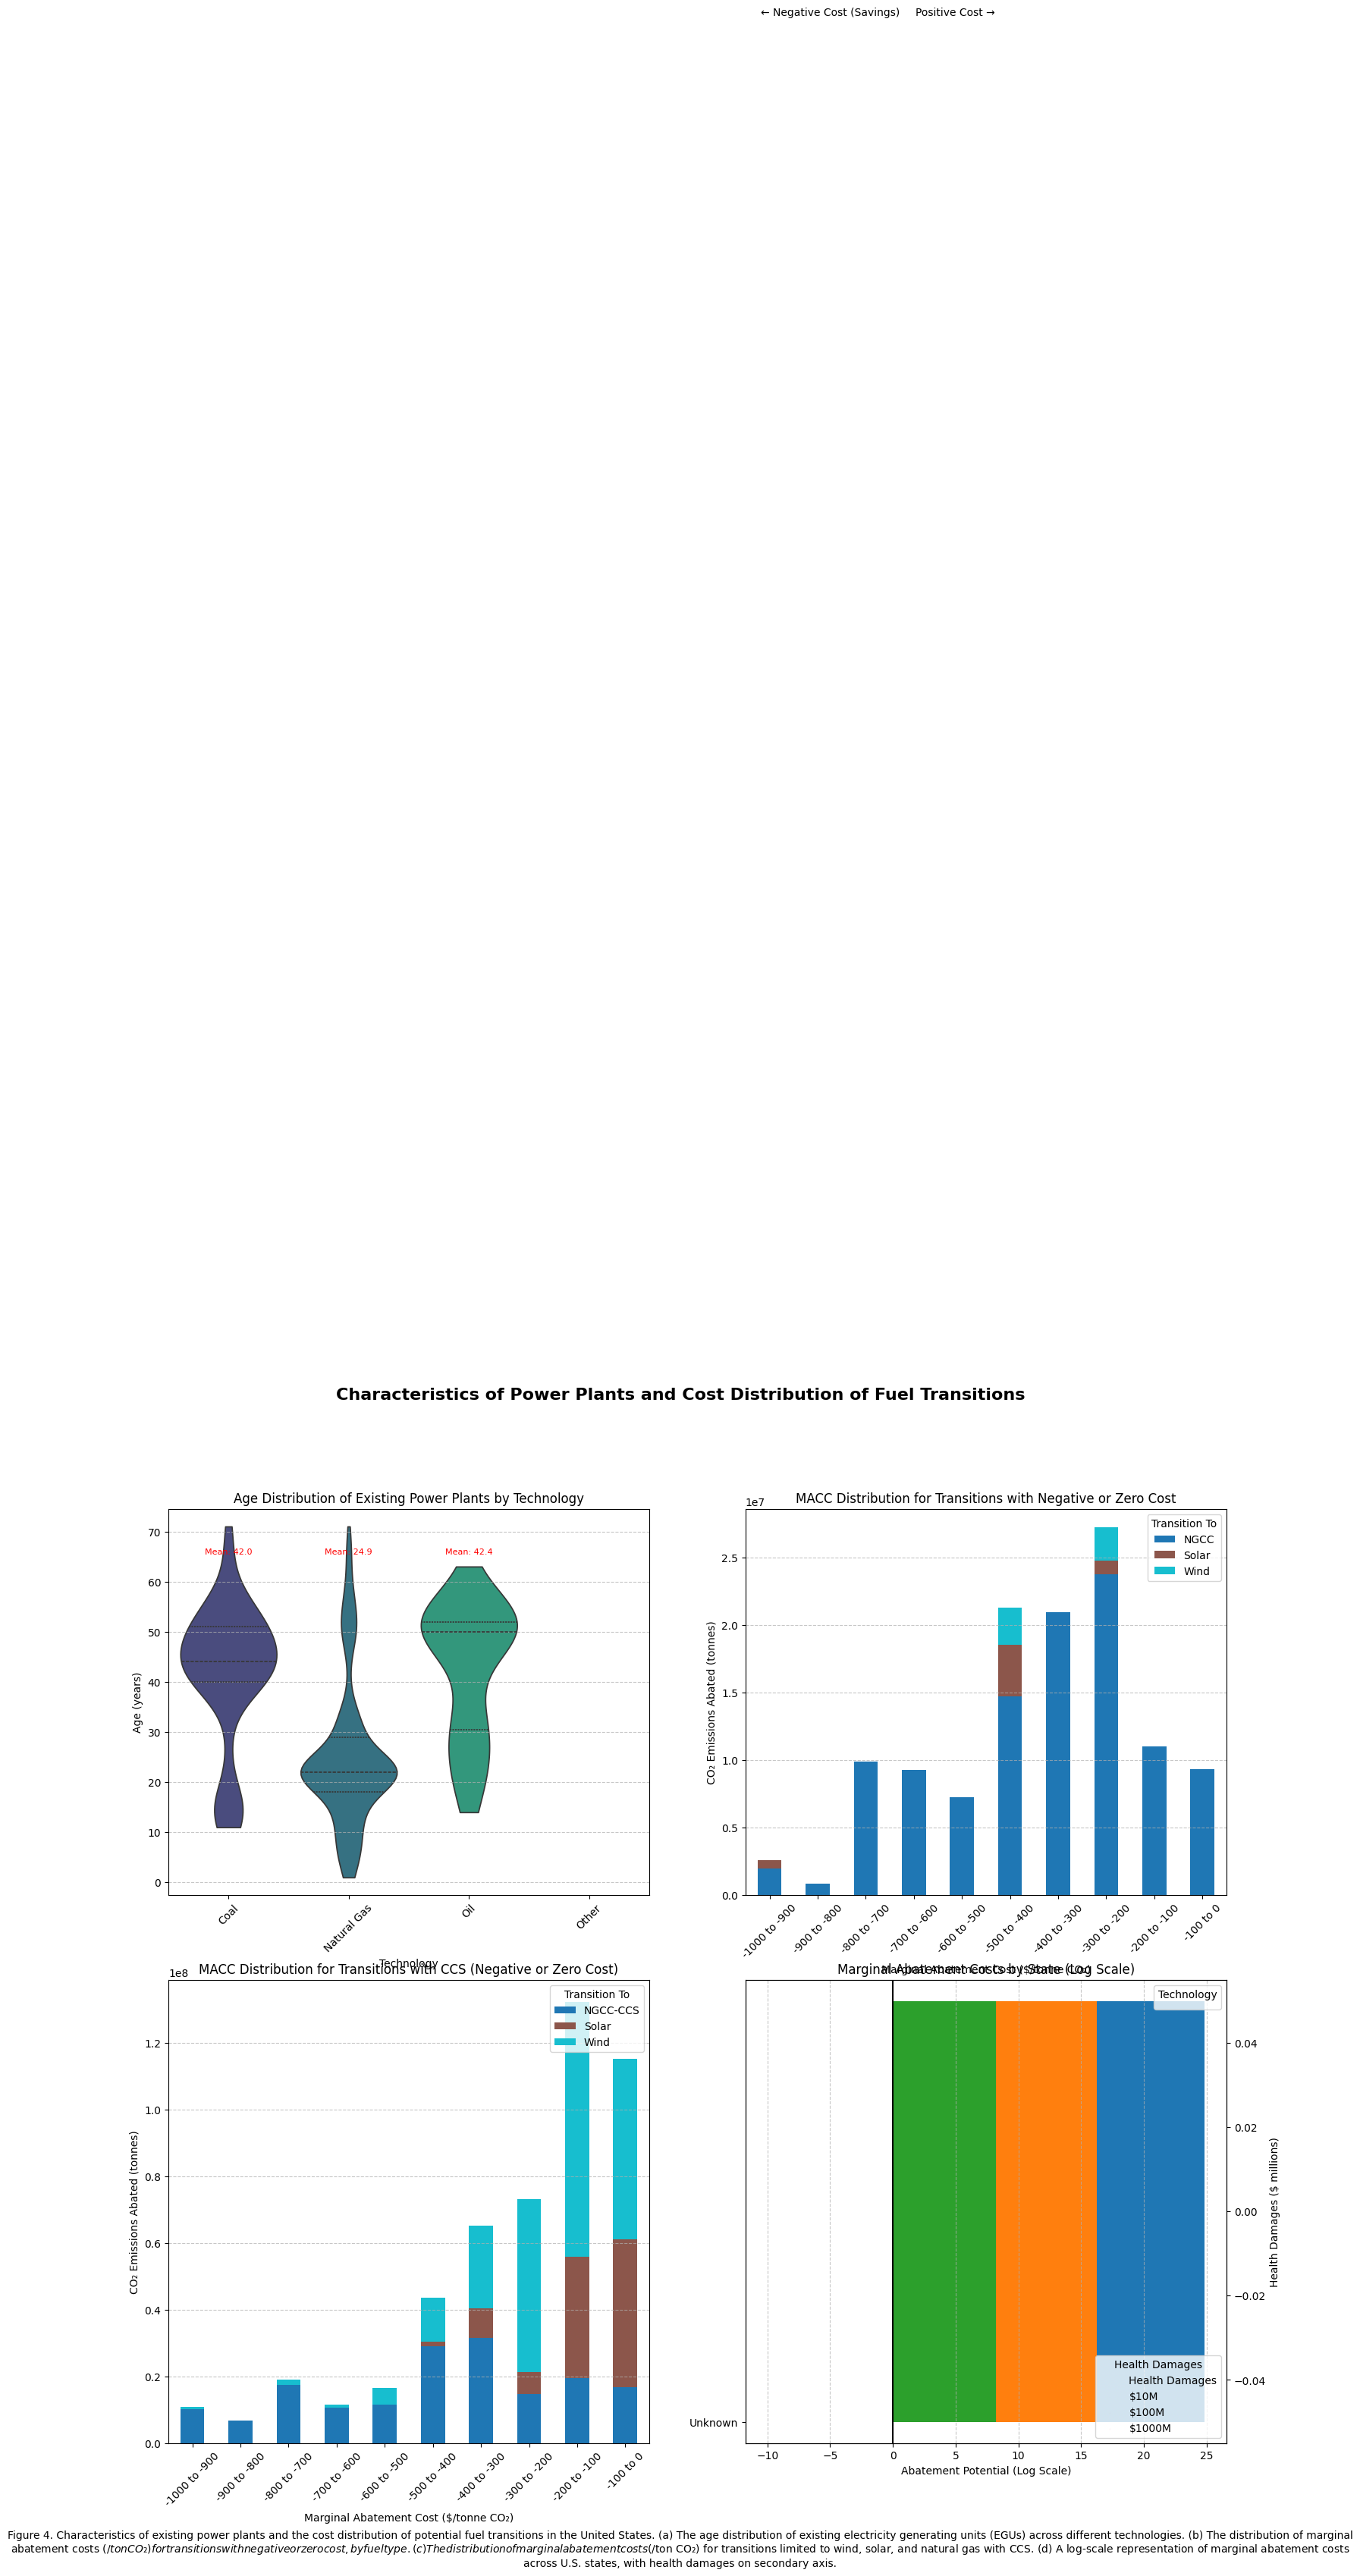

In [36]:
# Import the new functions
from figure4_implementation import (
    create_figure4_comprehensive, 
    plot_age_distribution, 
    plot_macc_distribution, 
    plot_macc_by_state, 
    prepare_health_damages_by_state
)

# Define paths to your data
baseline_dir = os.path.join(project_root, 'output', 'baseline')
ccs_dir = os.path.join(project_root, 'output', 'ccs_scenario')
air_pollution_dir = os.path.join(project_root, 'output', 'air_pollution')

# Load health damages by state if available
health_damages_path = os.path.join(air_pollution_dir, 'ngcc_conversion_by_state.csv')
health_damages_by_state = None
if os.path.exists(health_damages_path):
    health_damages_df = pd.read_csv(health_damages_path)
    health_damages_by_state = prepare_health_damages_by_state(health_damages_df)

# Create Figure 4
fig = create_figure4_comprehensive(
    config,                                      # Your configuration dictionary
    (merged_df, macc_data, summary),             # Baseline scenario data
    (ccs_merged_df, ccs_macc_data, ccs_summary), # CCS scenario data
    health_damages_by_state                      # Optional health damages data
)

plt.show()

2025-03-03 13:39:20,875 - macc_analysis - INFO - Running MACC analysis with CCS scenario: ccs_scenario
2025-03-03 13:39:20,877 - macc_analysis - INFO - Loaded emissions data with 1343 records
2025-03-03 13:39:20,879 - macc_analysis - INFO - Found 1121 unique facilities in emissions data
2025-03-03 13:39:30,284 - macc_analysis - INFO - Loaded plant data with 26011 records
2025-03-03 13:39:30,306 - macc_analysis - INFO - Filtered to 4092 plant records
/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_level_attributes.rename(columns={'Plant Code': 'Facility ID'}, inplace=True)
2025-03-03 13:39:30,482 - macc_analysis - INFO - Loaded capital cost data with 108 records
/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:314: SettingWithCopyW

Map visualization saved to /Users/dhruvsuri/Code/US-macc/output/baseline/ccs_scenario/transition_map_ccs.png


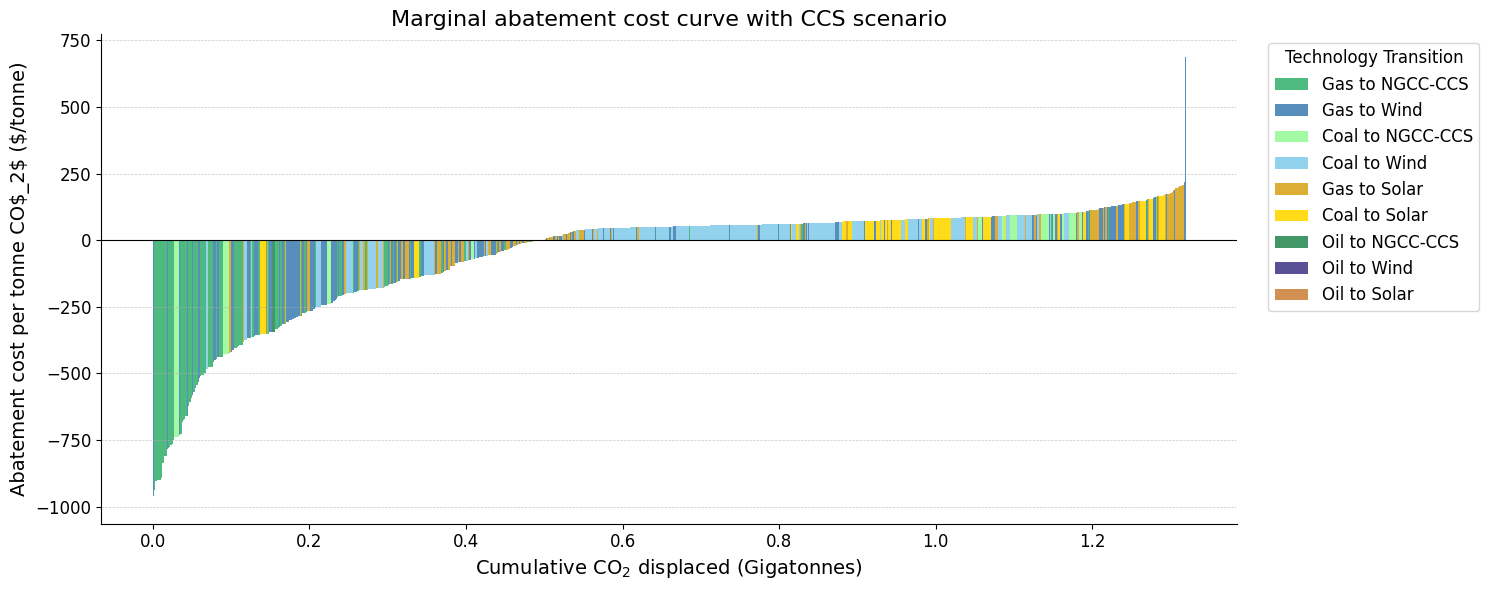

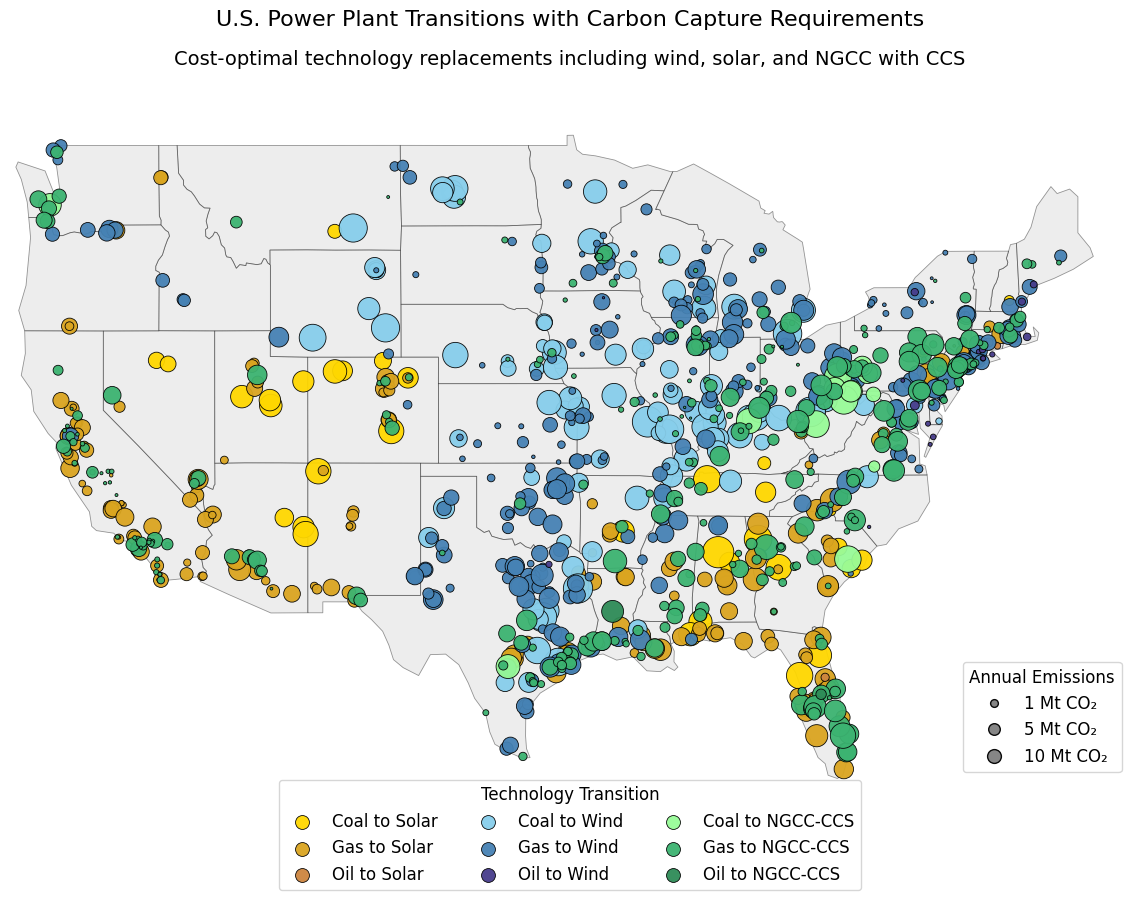

Baseline Scenario:
Total emissions: 0.77 Gt
Negative cost abatement: 15.6%
Facility count: 659

CCS Scenario:
Total emissions: 1.32 Gt
Negative cost abatement: 37.5%
Facility count: 907


In [7]:
# Run the CCS scenario
ccs_merged_df, ccs_macc_data, ccs_summary = macc.run_ccs_scenario(config, 'ccs_scenario')

# Create the transition map for the CCS scenario
ccs_map_fig = macc.create_transition_map_with_ccs(
    merged_df=ccs_merged_df,
    config=config,
    output_path=os.path.join(config['output_dir'], 'ccs_scenario', 'transition_map_ccs.png'),
    title="U.S. Power Plant Transitions with Carbon Capture Requirements"
)
plt.show()

# Compare to baseline scenario
print("Baseline Scenario:")
print(f"Total emissions: {summary['total_emissions_gt']:.2f} Gt")
print(f"Negative cost abatement: {summary['negative_cost_percentage']:.1f}%")
print(f"Facility count: {summary['facility_count']}")

print("\nCCS Scenario:")
print(f"Total emissions: {ccs_summary['total_emissions_gt']:.2f} Gt")
print(f"Negative cost abatement: {ccs_summary['negative_cost_percentage']:.1f}%")
print(f"Facility count: {ccs_summary['facility_count']}")

/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:1937: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  plants_with_county = gpd.sjoin(plants_gdf, continental_counties, how="left", predicate="within")
/Users/dhruvsuri/Code/US-macc/notebooks/macc_analysis.py:1968: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  county_renewable_potential['wind_cf']

Enhanced map visualization saved to /Users/dhruvsuri/Code/US-macc/output/baseline/enhanced_transition_map_ccs.png


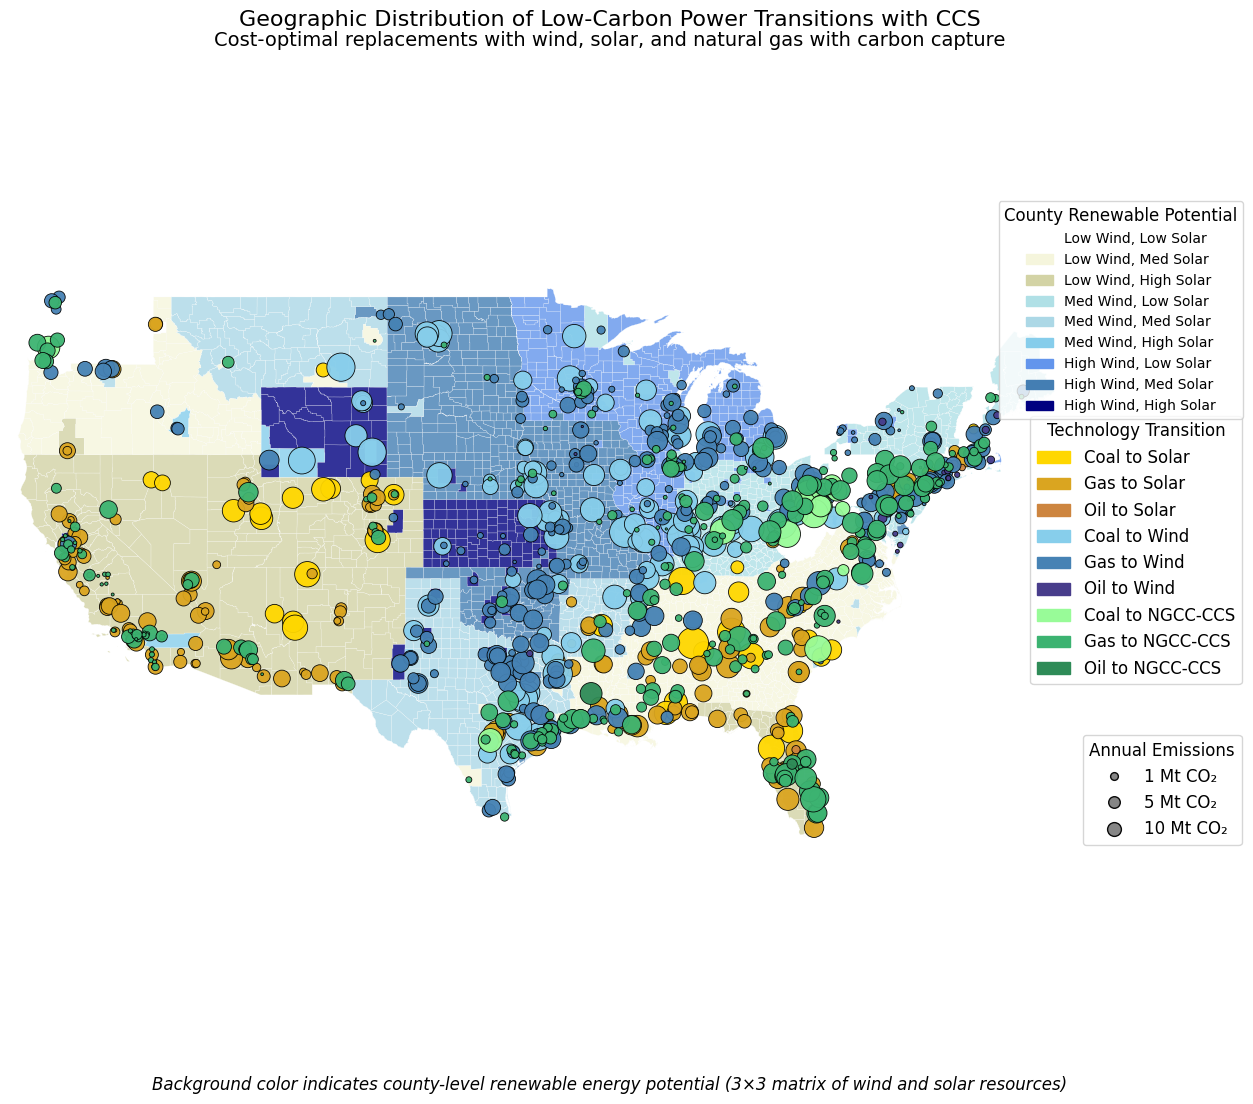

In [8]:
# For CCS scenario
fig_ccs = macc.create_enhanced_transition_map(
    merged_df=ccs_merged_df,
    config=config,
    ccs_scenario=True,
    output_path=os.path.join(config['output_dir'], 'enhanced_transition_map_ccs.png')
)
plt.show()

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap
from county_renewable_potential import overlay_transitions

# Load pre-calculated county renewable potential
county_path = os.path.join(config['output_dir'], 'renewable_potential', 'county_renewable_potential.csv')
county_renewable = pd.read_csv(county_path)

# Load county shapefile and join with renewable data
counties = gpd.read_file(os.path.join(config['data_dir'], 'raw/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'))
counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']
counties = counties.merge(county_renewable, on='FIPS', how='left')

# Create the custom colormap for the 3x3 matrix
resource_cmap = LinearSegmentedColormap.from_list(
    'resource_cmap', 
    ['#FFFFFF', '#F5F5DC', '#D3D3A4', 
     '#B0E0E6', '#ADD8E6', '#87CEEB', 
     '#6495ED', '#4682B4', '#000080']
)

# Plot the map and overlay plant transitions
fig, ax = plt.subplots(figsize=(16, 10))
counties.plot(column='resource_category', cmap=resource_cmap, ax=ax)
overlay_transitions(ax, counties, ccs_merged_df, ccs_scenario=True)
plt.title('Geographic Distribution of Low-Carbon Power Transitions with CCS', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dhruvsuri/Code/US-macc/output/baseline/renewable_potential/county_renewable_potential.csv'